# Задание **Pro**

Меняя параметры/гиперпараметры модели и подход к формированию выборки, добейтесь максимальной точности сетки.

# Импорт бибилиотек

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Reshape
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.model_selection import train_test_split
import IPython.display as ipd
from IPython.display import Audio
import librosa
import scipy.stats
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Объявление функций

In [ ]:
DATA_PATH = '/content/drive/MyDrive/УИИ/Распознавание речи/База comands/'
DATA_PATH_TEST = '/content/drive/MyDrive/УИИ/Распознавание речи/База test_speech/'

In [ ]:
#  Задаем стандартные параметры для всех аудиофайлов
sample_rate = 22050
feature_dim_1 = 20
feature_dim_2 = int(0.5 * sample_rate)
step_mfcc = int(0.02 * sample_rate)
channel = 1
n_classes = 4
classes = ['КОНДИЦИОНЕР', 'СВЕТ', 'ТЕЛЕВИЗОР']

In [ ]:
# Функция извлечения лейблов классов
def get_labels(path = DATA_PATH):
  labels = sorted(os.listdir(path))
  label_indices = np.arange(0, len(labels))
  return labels, label_indices, to_categorical(label_indices)

In [ ]:
l, l_i, to_cat = get_labels()
print(l)
print(l_i)
print(to_cat)

['1_cond', '2_light', '3_tv', '4_noise']
[0 1 2 3]
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [ ]:
# Функция параметризации аудио
def wav2mfcc(file_path, length=11025, step=2205):
  out_mfcc = []
  out_audio = []
  y, sr = librosa.load(file_path)

  while (len(y) > length):
    section = y[:length]
    section = np.array(section)
    out_mfcc.append(librosa.feature.mfcc(section, sr))
    out_audio.append(section)
    y = y[step:]
  
  out_mfcc = np.array(out_mfcc)
  out_audio = np.array(out_audio)

  return out_mfcc, out_audio

In [ ]:
# Функция формирования и сохранения векторов данных
def save_data_to_array(path=DATA_PATH, length=11025):
  labels, _, _ = get_labels(path)
  for label in labels:
    mfcc_vectors = []
    wavfiles = [path + label + '/' + wavfile for wavfile in os.listdir(path + label)]
    for wavfile in tqdm(wavfiles,  f"Сохраняем векторы класса - {label}"):
      mfcc, _ = wav2mfcc(wavfile, length=length, step = step_mfcc)
      if mfcc.shape[0] != 0:
        mfcc_vectors.extend(mfcc)
    np.save(label + '.npy', mfcc_vectors)

In [ ]:
# Функция для получения обучающей/проверочной выборки
def get_train_test(split_ratio=0.8, random_state=42, colab=False):
  labels, indices, _ = get_labels(DATA_PATH)

  X = np.load('/content/drive/MyDrive/УИИ/Распознавание речи/Numpy/' + labels[0] + '.npy')
  y = np.zeros(X.shape[0], dtype='int32')

  for i, label in enumerate(labels[1:]):
    if colab:
      x = np.load(label + '.npy')
    else:
      x = np.load('/content/drive/MyDrive/УИИ/Распознавание речи/Numpy/' + label + '.npy')

    X = np.vstack((X, x))
    y = np.append(y, np.full(x.shape[0], fill_value= (i + 1)))
  
  return train_test_split(X, y, test_size=(1-split_ratio), random_state=random_state, shuffle=True)


# Подготовка данных

In [ ]:
# Сформируем векторные данные и сохраним
save_data_to_array(length=feature_dim_2)

In [ ]:
# Формируем обучающую и проверочную выборки
x_train, x_test, y_train, y_test = get_train_test()
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(64343, 20, 22)
(16086, 20, 22)
(64343,)
(16086,)


In [ ]:
# Добавляем значение канала
x_train = x_train[..., None]
x_test = x_test[..., None]

print(x_train.shape)
print(x_test.shape)

(64343, 20, 22, 1)
(16086, 20, 22, 1)


In [ ]:
# представляем лейблы классов обучающего набора в виде one-hot вектора
y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)

print(y_train_hot.shape)
print(y_test_hot.shape)

(64343, 4)
(16086, 4)


In [ ]:
# Посмотрим сколько всего 3 категории
ind = np.where(y_train==3)
ind[0].shape

(57997,)

# Создание и обучение нейронной сети

In [ ]:
# Функция создания модели нейросети
def get_model():
  model = Sequential()
  model.add(Conv2D(8, kernel_size=(3,3), activation='relu', input_shape=(x_train.shape[1], x_train.shape[2], channel)))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(BatchNormalization())
  model.add(Flatten())
  model.add(Dense(128,activation='relu'))
  model.add(Dropout(0.25))
  model.add(BatchNormalization())
  model.add(Dense(n_classes, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
  return model

In [ ]:
model = get_model()

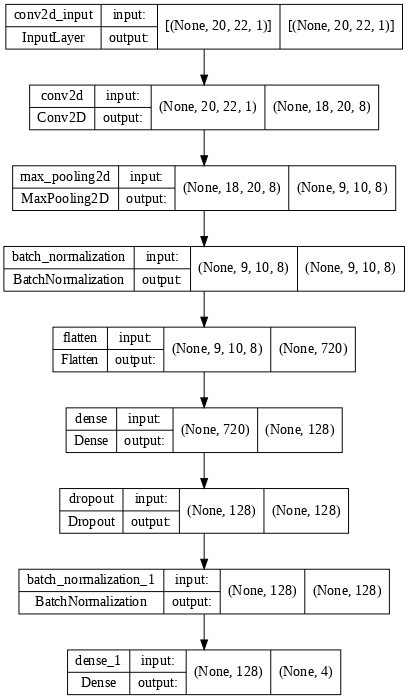

In [ ]:
plot_model(model, show_shapes=True, dpi=70)

## Обучение нейронной сети

In [ ]:
history = model.fit(x_train, y_train_hot, batch_size=256, epochs=40, validation_data=(x_test, y_test_hot), verbose=1)

Epoch 1/40
252/252 [==============================] - 13s 44ms/step - loss: 0.2543 - accuracy: 0.9268 - val_loss: 0.0395 - val_accuracy: 0.9917
Epoch 2/40
252/252 [==============================] - 10s 42ms/step - loss: 0.0342 - accuracy: 0.9899 - val_loss: 0.0295 - val_accuracy: 0.9949
Epoch 3/40
252/252 [==============================] - 12s 48ms/step - loss: 0.0208 - accuracy: 0.9933 - val_loss: 0.0142 - val_accuracy: 0.9964
Epoch 4/40
252/252 [==============================] - 11s 43ms/step - loss: 0.0151 - accuracy: 0.9950 - val_loss: 0.0113 - val_accuracy: 0.9958
Epoch 5/40
252/252 [==============================] - 12s 47ms/step - loss: 0.0134 - accuracy: 0.9955 - val_loss: 0.0094 - val_accuracy: 0.9965
Epoch 6/40
252/252 [==============================] - 11s 42ms/step - loss: 0.0108 - accuracy: 0.9965 - val_loss: 0.0078 - val_accuracy: 0.9978
Epoch 7/40
252/252 [==============================] - 11s 42ms/step - loss: 0.0102 - accuracy: 0.9963 - val_loss: 0.0068 - val_accuracy:

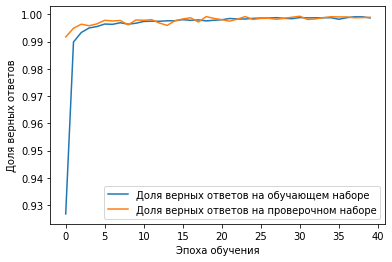

In [ ]:
plt.plot(history.history['accuracy'], label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

# Проверка

In [ ]:
#wavfiles =  DATA_PATH_TEST + 'text_with_svet9.wav'
wavfiles =  DATA_PATH_TEST + 'text_with_cond3.wav'
y, sr = librosa.load(wavfiles)
ipd.Audio(data=y, rate=sr)

In [ ]:
mfcc_full, audio_full = wav2mfcc (wavfiles, length=feature_dim_2, step = step_mfcc)

In [ ]:
print(mfcc_full.shape)
print(audio_full.shape)


(1425, 20, 22)
(1425, 11025)


In [ ]:
# Решейпим для сверточного слоя
mfcc_full = mfcc_full.reshape(-1, 20, 22, 1)
print(mfcc_full.shape)


(1425, 20, 22, 1)


In [ ]:
# Предиктим
g_pred = model.predict(mfcc_full)
print(g_pred.shape)

(1425, 4)


In [ ]:
# Выбираем индекс максимального элемента в каждом g_pred[i]
pred = np.array([np.argmax(i) for i in g_pred])
print(pred.shape)

(1425,)


In [ ]:
pred

array([3, 3, 3, ..., 3, 3, 3])

In [ ]:
pred[:1000]

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [ ]:
# В массиве pred находим все элементы со значением, равным искомому классу idx_class
# Свет - 1 класс
indx = np.where(pred == 0)
print(indx)
print(indx[0].shape)

(array([ 20,  22,  23,  24,  25,  26,  27,  28,  29,  30,  32,  34, 456,
       458, 460, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659,
       660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672,
       673, 674, 675, 937, 938]),)
(44,)


In [ ]:
indx = indx[0]

In [ ]:
curr = []
curr_idx = int(indx[0])
summ, length = 0, 0
for i in range(len(indx)):
  summ += g_pred[indx[i]][0]
  length += 1
  if i == len(indx)-1:
    if (length >= 2 and summ / length >= 0.95):
      curr.append([curr_idx, length, summ / length])
    break        
  if indx[i+1]-indx[i]>1:
    if (length >= 8 and summ / length >= 0.95):
      curr.append([curr_idx, length, summ / length])
    curr_idx = int (indx[i+1])
    summ, length = 0, 0
print (curr)

[[649, 27, 0.9898957897115637]]


In [ ]:
np_Audio = []
curr_audio = []
for elem in curr:
  curr_audio = audio_full[elem[0]]
  if (elem[0] != 0):
    curr_audio = np.hstack((audio_full[elem[0] - 1], audio_full[elem[0]][-step_mfcc:]))        
  for j in range(1,elem[1]):
    if (elem[0]+j == len(audio_full)):
      break    
    curr_audio = np.hstack((curr_audio, audio_full[elem[0]+j][-step_mfcc:]))
  curr_audio = np.array(curr_audio)
  np_Audio.append([curr_audio, elem[2]])

print (len(curr_audio))

22932


In [ ]:
if (len(np_Audio)==0):
    print('Команда не распознанана')
for elem in np_Audio: 
    print ('Распознана команда: "', classes[0], '" (вероятность - %.2f' % (elem[1]*100), '%)')
    ipd.display(ipd.Audio (elem[0], rate = 22050))

Распознана команда: " КОНДИЦИОНЕР " (вероятность - 98.99 %)


# Создаем функцию

In [ ]:
def predict(namefile, model, min_count = 2, rate = 0.9, hole = 1):

  mfcc_full, audio_full = wav2mfcc (namefile, length=feature_dim_2, step = step_mfcc)
  mfcc_full = mfcc_full.reshape(-1, 20, 22, 1)
  g_pred = model.predict(mfcc_full)
  pred = np.array([np.argmax(i) for i in g_pred])

  out = [] 
  for idx_class in range(n_classes-1):
    idxs = np.where(pred == idx_class)
    idxs = idxs[0]
    if (len(idxs) == 0):
      continue

    curr = []
    curr_idx =int(idxs[0]) # Текущий стартовый индекс
    summ, length = 0, 0 # summ - хранит сумму вероятностей, с которой сеть отнесла команду к данному классу; length - длинна последовательно идущих элементов для одной команды (для массива curr из примера                                                                        
                                                                  #[4, 123] длина соответствующая первому элементу будет 4, второму - 5 )
    for i in range(len(idxs)): # Пробегаем по всему массиву idxs
      summ += g_pred[idxs[i]][idx_class] # Считаем сумму вероятности
      length += 1 # Увеличиваем длинну последовательности
      if i == len(idxs)-1: # Если последний элемент последовательности
        if (length >= min_count and summ / length >= rate): # Проверяем на условия разбора: длинна последовательности должна быть больше входного параметра min_count
                                                            # summ / length должно быть больше входного параметра rate
          curr.append([curr_idx, length, summ / length]) # Если условия выполняются, то добавляем в маасив стартовый индекс найденной команды, длинну последовательности и summ / length

        break  
      if idxs[i+1]-idxs[i]>hole: # Если следующий индекс больше текущего на hole (означает, что следующий элемент относится уже к другой комманде)
        if (length >= min_count and summ / length >= rate): # Проверяем на условия разбора: длинна последовательности должна быть больше входного параметра min_count
                                                            # summ / length должно быть больше входного параметра rate
          print(length)
          curr.append([curr_idx, length, summ / length]) # Если условия выполняются, то добавляем в маасив стартовый индекс найденной команды, длинну последовательности и summ / length
        curr_idx = int (idxs[i+1]) # Изменяем текущий стартовый индекс
        summ, length = 0, 0 # Обнуляем summ и length
    curr_audio = [] # mfcc отдельной команды
    for elem in curr: # Проходим по всему массиву curr
      #if (elem[0] != 0): # Если это не самый первый элемент исходных данных, то возьмем на одну mfcc левее (чаще всего там будет либо тишина, либо начало команды, которое не разобралось сетью)
      #  curr_audio = np.concatenate((audio_full[elem[0] - 1], audio_full[elem[0]][:, -step_mfcc:,:]), axis = 0)
      #else:
      curr_audio = audio_full[elem[0]] # Если это стартовый элемент исходных данных, то берем самую первую mfcc
      for j in range(1,elem[1]): # Пробегаем цикл от 1 до elem[1]+1 (где elem[1] хранит длинну последовательности элементов, отнесенных к одной команде)
        if (elem[0]+j == len(audio_full)): # Если elem[0] + j равно длинне mfcc, то выходим из цикла
          break
        #curr_audio = np.concatenate((curr_audio, audio_full[elem[0] + j][:,-step_mfcc:,:]), axis = 1) # Создаем единий mfcc, использую concatenate для добавления к текущему значению срез динной step_mfcc из следующего элемента
        curr_audio = np.hstack((curr_audio, audio_full[elem[0]+j][-step_mfcc:]))
      curr_audio = np.array(curr_audio) # Переводим массив в numpy
      #curr_mfcc = curr_mfcc.reshape (curr_mfcc.shape[0], curr_mfcc.shape[1]) # Убираем третью размерность
      #curr_mfcc_unscaled= xScaler.inverse_transform(curr_mfcc)
      #recon = librosa.feature.inverse.mfcc_to_audio(curr_mfcc_unscaled) # Получаем ауди из mfcc
      out.append([curr_audio, idx_class, elem[2]]) # Добавляем данные в выходной массив
  return out, pred, g_pred # Возращаем массив с данными, массив с классами команд, массив с softmax данными

# Различные проверки

## Кондиционер

In [ ]:
wavfiles =  DATA_PATH_TEST + 'text_with_cond7.wav'
out, pred, _ = predict(wavfiles, model=model, min_count = 6, rate = 0.8, hole = 2)
if (len(out)==0):
  print('Команда не распознанана!!!')
for elem in out:
  print ('Распознана команда: "', classes[elem[1]], '" (вероятность - %.2f' % (elem[2]*100), '%)')
  ipd.display(ipd.Audio (elem[0], rate = 22050))

Распознана команда: " КОНДИЦИОНЕР " (вероятность - 97.38 %)


## Свет

In [ ]:
wavfiles =  DATA_PATH_TEST + 'text_with_svet1.wav'
out, pred, _ = predict(wavfiles, model=model, min_count = 6, rate = 0.9, hole = 1)
if (len(out)==0):
  print('Команда не распознанана!!!')
for elem in out:
  print ('Распознана команда: "', classes[elem[1]], '" (вероятность - %.2f' % (elem[2]*100), '%)')
  ipd.display(ipd.Audio (elem[0], rate = 22050))

Распознана команда: " СВЕТ " (вероятность - 98.30 %)


## Телевизор

In [ ]:
wavfiles =  DATA_PATH_TEST + 'text_with_televizor2.wav'
out, pred, _ = predict(wavfiles, model=model, min_count = 6, rate = 0.9, hole = 1)
if (len(out)==0):
  print('Команда не распознанана!!!')
for elem in out:
  print ('Распознана команда: "', classes[elem[1]], '" (вероятность - %.2f' % (elem[2]*100), '%)')
  ipd.display(ipd.Audio (elem[0], rate = 22050))


Распознана команда: " ТЕЛЕВИЗОР " (вероятность - 99.41 %)


# Основное задание
Меняя параметры/гиперпараметры модели и подход к формированию выборки, добейтесь максимальной точности сетки.

Возьмем за основую нейронную сеть из предыдущих заданий и будем изменять ее, добиваясь лучших результатов.

## 1. Добавление **новых** сверточных слоев

In [ ]:
model = Sequential()
model.add(Conv2D(8, kernel_size=(3,3), activation='relu', input_shape=(x_train.shape[1], x_train.shape[2], channel)))
model.add(Conv2D(8, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(8, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(8, kernel_size=(3,3), activation='relu'))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Dense(n_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

### Просмотр модели

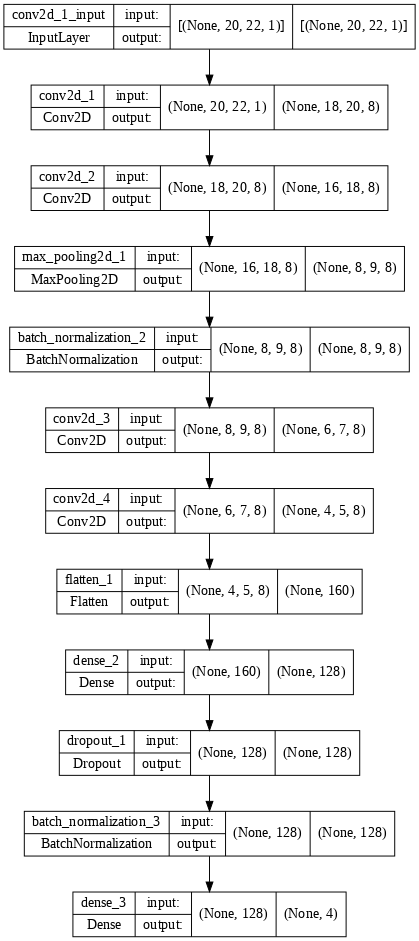

In [ ]:
plot_model(model, show_shapes=True, dpi=70)

### Обучение и график

Epoch 1/50
252/252 [==============================] - 19s 8ms/step - loss: 0.3657 - accuracy: 0.8741 - val_loss: 0.1073 - val_accuracy: 0.9653
Epoch 2/50
252/252 [==============================] - 2s 6ms/step - loss: 0.0568 - accuracy: 0.9817 - val_loss: 0.0380 - val_accuracy: 0.9866
Epoch 3/50
252/252 [==============================] - 2s 6ms/step - loss: 0.0329 - accuracy: 0.9890 - val_loss: 0.0262 - val_accuracy: 0.9917
Epoch 4/50
252/252 [==============================] - 2s 7ms/step - loss: 0.0199 - accuracy: 0.9933 - val_loss: 0.0160 - val_accuracy: 0.9949
Epoch 5/50
252/252 [==============================] - 2s 7ms/step - loss: 0.0149 - accuracy: 0.9950 - val_loss: 0.0121 - val_accuracy: 0.9959
Epoch 6/50
252/252 [==============================] - 2s 7ms/step - loss: 0.0121 - accuracy: 0.9956 - val_loss: 0.0139 - val_accuracy: 0.9952
Epoch 7/50
252/252 [==============================] - 2s 6ms/step - loss: 0.0115 - accuracy: 0.9963 - val_loss: 0.0072 - val_accuracy: 0.9976
Epoch

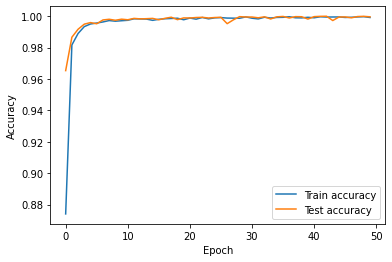

In [ ]:
history = model.fit(x_train, y_train_hot, batch_size=256, epochs=50, validation_data=(x_test, y_test_hot), verbose=1)

plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 2. Изменение **количества** **фильтров** в сверточных слоях

In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(x_train.shape[1], x_train.shape[2], channel)))
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Dense(n_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

### Обучение и график

In [ ]:
history = model.fit(x_train, y_train_hot, batch_size=256, epochs=50, validation_data=(x_test, y_test_hot), verbose=1)

Epoch 1/50
252/252 [==============================] - 3s 10ms/step - loss: 0.2293 - accuracy: 0.9350 - val_loss: 0.0341 - val_accuracy: 0.9904
Epoch 2/50
252/252 [==============================] - 2s 9ms/step - loss: 0.0188 - accuracy: 0.9948 - val_loss: 0.0120 - val_accuracy: 0.9971
Epoch 3/50
252/252 [==============================] - 2s 8ms/step - loss: 0.0094 - accuracy: 0.9970 - val_loss: 0.0073 - val_accuracy: 0.9980
Epoch 4/50
252/252 [==============================] - 2s 8ms/step - loss: 0.0056 - accuracy: 0.9985 - val_loss: 0.0036 - val_accuracy: 0.9992
Epoch 5/50
252/252 [==============================] - 2s 8ms/step - loss: 0.0055 - accuracy: 0.9982 - val_loss: 0.0120 - val_accuracy: 0.9955
Epoch 6/50
252/252 [==============================] - 2s 9ms/step - loss: 0.0082 - accuracy: 0.9973 - val_loss: 0.0034 - val_accuracy: 0.9991
Epoch 7/50
252/252 [==============================] - 2s 9ms/step - loss: 0.0024 - accuracy: 0.9992 - val_loss: 0.0181 - val_accuracy: 0.9951
Epoch

## 3. Добавление **MaxPooling2D** после второго блока сверточных слоев

In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(x_train.shape[1], x_train.shape[2], channel)))
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Dense(n_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

### Обучение и график

In [ ]:
history = model.fit(x_train, y_train_hot, batch_size=256, epochs=50, validation_data=(x_test, y_test_hot), verbose=1)

Epoch 1/50
252/252 [==============================] - 3s 10ms/step - loss: 0.2997 - accuracy: 0.9071 - val_loss: 0.0693 - val_accuracy: 0.9779
Epoch 2/50
252/252 [==============================] - 2s 9ms/step - loss: 0.0291 - accuracy: 0.9916 - val_loss: 0.0135 - val_accuracy: 0.9965
Epoch 3/50
252/252 [==============================] - 2s 9ms/step - loss: 0.0164 - accuracy: 0.9947 - val_loss: 0.0375 - val_accuracy: 0.9883
Epoch 4/50
252/252 [==============================] - 2s 8ms/step - loss: 0.0098 - accuracy: 0.9968 - val_loss: 0.0078 - val_accuracy: 0.9974
Epoch 5/50
252/252 [==============================] - 2s 8ms/step - loss: 0.0095 - accuracy: 0.9970 - val_loss: 0.0167 - val_accuracy: 0.9943
Epoch 6/50
252/252 [==============================] - 2s 8ms/step - loss: 0.0068 - accuracy: 0.9977 - val_loss: 0.0087 - val_accuracy: 0.9961
Epoch 7/50
252/252 [==============================] - 2s 8ms/step - loss: 0.0063 - accuracy: 0.9977 - val_loss: 0.0103 - val_accuracy: 0.9972
Epoch

In [ ]:
wavfiles =  DATA_PATH_TEST + 'text_with_televizor2.wav'
out, pred, _ = predict(wavfiles, model=model, min_count = 6, rate = 0.9, hole = 1)
if (len(out)==0):
  print('Команда не распознанана!!!')
for elem in out:
  print ('Распознана команда: "', classes[elem[1]], '" (вероятность - %.2f' % (elem[2]*100), '%)')
  ipd.display(ipd.Audio (elem[0], rate = 22050))

10
22
Распознана команда: " КОНДИЦИОНЕР " (вероятность - 97.90 %)


Распознана команда: " ТЕЛЕВИЗОР " (вероятность - 96.27 %)


Распознана команда: " ТЕЛЕВИЗОР " (вероятность - 93.70 %)


In [ ]:
wavfiles =  DATA_PATH_TEST + 'text_with_svet1.wav'
out, pred, _ = predict(wavfiles, model=model, min_count = 6, rate = 0.9, hole = 1)
if (len(out)==0):
  print('Команда не распознанана!!!')
for elem in out:
  print ('Распознана команда: "', classes[elem[1]], '" (вероятность - %.2f' % (elem[2]*100), '%)')
  ipd.display(ipd.Audio (elem[0], rate = 22050))

Распознана команда: " СВЕТ " (вероятность - 99.99 %)


Распознана команда: " ТЕЛЕВИЗОР " (вероятность - 94.59 %)


# 4. Добавление слоя **Dropout** после сверточных слоев

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(x_train.shape[1], x_train.shape[2], channel)))
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Dense(n_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

### Просмотр модели

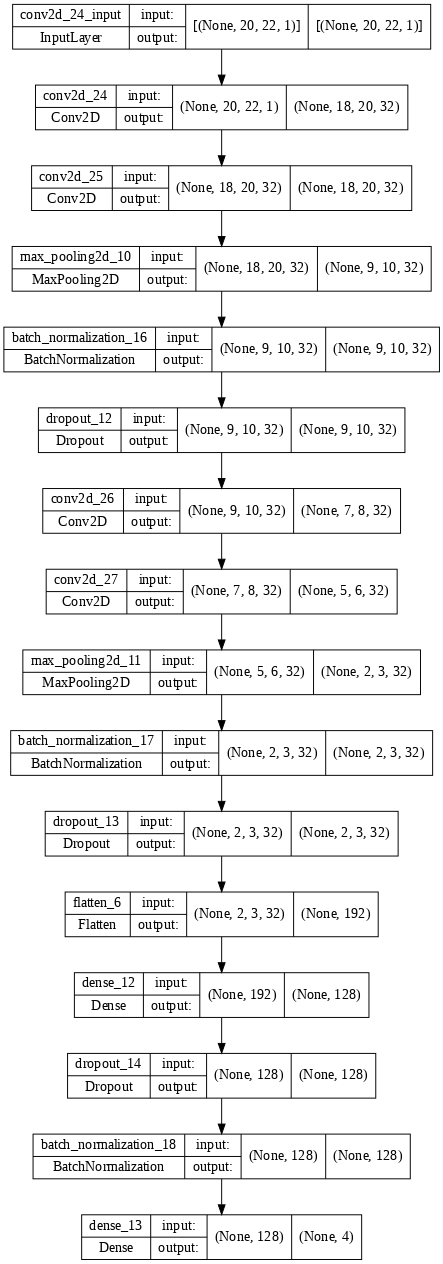

In [ ]:
plot_model(model, show_shapes=True, dpi=70)

### Обучение и график

Epoch 1/50
252/252 [==============================] - 4s 13ms/step - loss: 0.3153 - accuracy: 0.9015 - val_loss: 0.0471 - val_accuracy: 0.9861
Epoch 2/50
252/252 [==============================] - 3s 10ms/step - loss: 0.0453 - accuracy: 0.9859 - val_loss: 0.0258 - val_accuracy: 0.9910
Epoch 3/50
252/252 [==============================] - 3s 10ms/step - loss: 0.0239 - accuracy: 0.9921 - val_loss: 0.0091 - val_accuracy: 0.9976
Epoch 4/50
252/252 [==============================] - 3s 10ms/step - loss: 0.0160 - accuracy: 0.9945 - val_loss: 0.0060 - val_accuracy: 0.9987
Epoch 5/50
252/252 [==============================] - 3s 10ms/step - loss: 0.0145 - accuracy: 0.9948 - val_loss: 0.0118 - val_accuracy: 0.9956
Epoch 6/50
252/252 [==============================] - 3s 10ms/step - loss: 0.0105 - accuracy: 0.9966 - val_loss: 0.0267 - val_accuracy: 0.9905
Epoch 7/50
252/252 [==============================] - 3s 10ms/step - loss: 0.0163 - accuracy: 0.9944 - val_loss: 0.0056 - val_accuracy: 0.9985

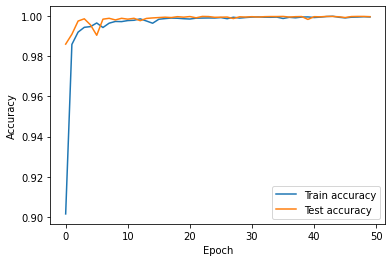

In [ ]:
history = model.fit(x_train, y_train_hot, batch_size=256, epochs=50, validation_data=(x_test, y_test_hot), verbose=1)

plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 5. Добавление параметра **padding='same'** в слоях Conv2D

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(x_train.shape[1], x_train.shape[2], channel)))
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Dense(n_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

### Просмотр модели

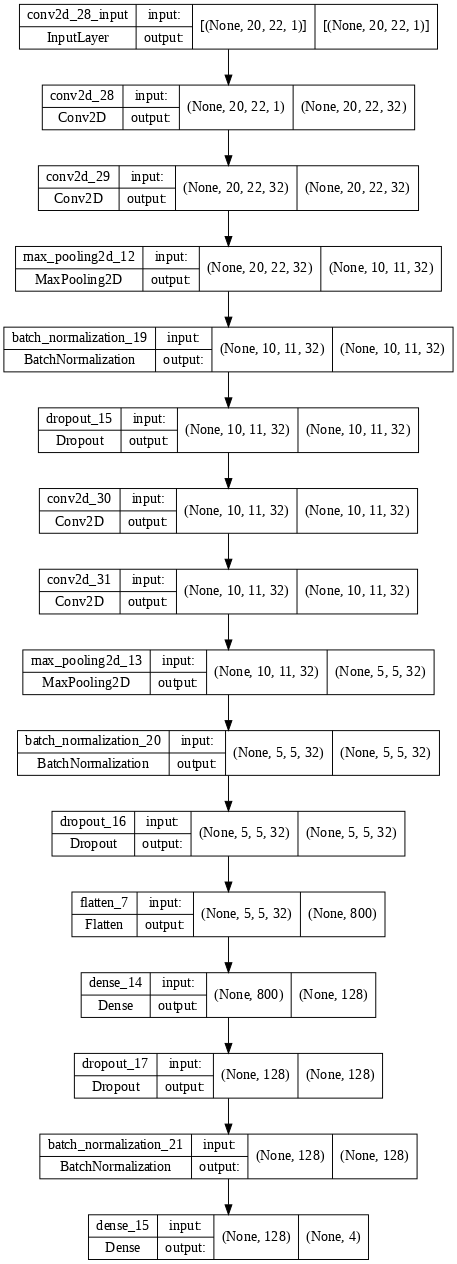

In [ ]:
plot_model(model, show_shapes=True, dpi=70)

### Обучение и график

Epoch 1/50
252/252 [==============================] - 5s 14ms/step - loss: 0.3118 - accuracy: 0.9003 - val_loss: 0.0374 - val_accuracy: 0.9873
Epoch 2/50
252/252 [==============================] - 3s 12ms/step - loss: 0.0365 - accuracy: 0.9888 - val_loss: 0.0134 - val_accuracy: 0.9963
Epoch 3/50
252/252 [==============================] - 3s 13ms/step - loss: 0.0181 - accuracy: 0.9942 - val_loss: 0.0082 - val_accuracy: 0.9971
Epoch 4/50
252/252 [==============================] - 3s 12ms/step - loss: 0.0133 - accuracy: 0.9957 - val_loss: 0.0075 - val_accuracy: 0.9968
Epoch 5/50
252/252 [==============================] - 3s 12ms/step - loss: 0.0110 - accuracy: 0.9962 - val_loss: 0.0046 - val_accuracy: 0.9988
Epoch 6/50
252/252 [==============================] - 3s 13ms/step - loss: 0.0084 - accuracy: 0.9971 - val_loss: 0.0042 - val_accuracy: 0.9988
Epoch 7/50
252/252 [==============================] - 3s 13ms/step - loss: 0.0066 - accuracy: 0.9977 - val_loss: 0.0041 - val_accuracy: 0.9986

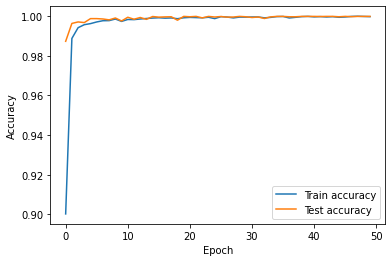

In [ ]:
history = model.fit(x_train, y_train_hot, batch_size=256, epochs=50, validation_data=(x_test, y_test_hot), verbose=1)

plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 6. Убрать второй блок **Conv2D** слоев и добавить **Dense** слои

In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(x_train.shape[1], x_train.shape[2], channel)))
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Dense(n_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

### Просмотр модели

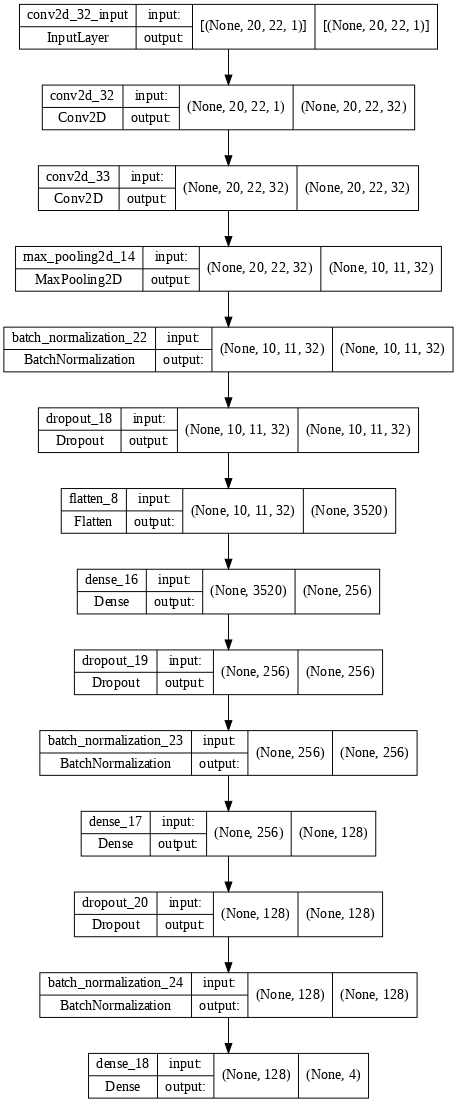

In [ ]:
plot_model(model, show_shapes=True, dpi=70)

### Обучение и график

Epoch 1/50
252/252 [==============================] - 4s 11ms/step - loss: 0.2839 - accuracy: 0.9081 - val_loss: 0.0267 - val_accuracy: 0.9907
Epoch 2/50
252/252 [==============================] - 3s 10ms/step - loss: 0.0300 - accuracy: 0.9909 - val_loss: 0.0168 - val_accuracy: 0.9940
Epoch 3/50
252/252 [==============================] - 3s 10ms/step - loss: 0.0216 - accuracy: 0.9931 - val_loss: 0.0125 - val_accuracy: 0.9962
Epoch 4/50
252/252 [==============================] - 3s 11ms/step - loss: 0.0131 - accuracy: 0.9956 - val_loss: 0.0068 - val_accuracy: 0.9977
Epoch 5/50
252/252 [==============================] - 3s 10ms/step - loss: 0.0121 - accuracy: 0.9959 - val_loss: 0.0192 - val_accuracy: 0.9925
Epoch 6/50
252/252 [==============================] - 3s 10ms/step - loss: 0.0134 - accuracy: 0.9956 - val_loss: 0.0097 - val_accuracy: 0.9967
Epoch 7/50
252/252 [==============================] - 3s 10ms/step - loss: 0.0080 - accuracy: 0.9970 - val_loss: 0.0077 - val_accuracy: 0.9973

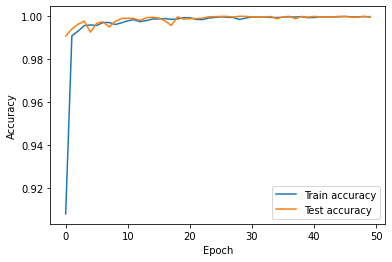

In [ ]:
history = model.fit(x_train, y_train_hot, batch_size=256, epochs=50, validation_data=(x_test, y_test_hot), verbose=1)

plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 7. Изменим кол-во нейронов в **Dense** слоях

In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(x_train.shape[1], x_train.shape[2], channel)))
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512,activation='relu'))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Dense(n_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

### Обучение и график

Epoch 1/50
252/252 [==============================] - 4s 12ms/step - loss: 0.1963 - accuracy: 0.9373 - val_loss: 0.0677 - val_accuracy: 0.9807
Epoch 2/50
252/252 [==============================] - 3s 11ms/step - loss: 0.0235 - accuracy: 0.9931 - val_loss: 0.0112 - val_accuracy: 0.9962
Epoch 3/50
252/252 [==============================] - 3s 10ms/step - loss: 0.0139 - accuracy: 0.9956 - val_loss: 0.0106 - val_accuracy: 0.9970
Epoch 4/50
252/252 [==============================] - 3s 10ms/step - loss: 0.0092 - accuracy: 0.9970 - val_loss: 0.0038 - val_accuracy: 0.9987
Epoch 5/50
252/252 [==============================] - 3s 11ms/step - loss: 0.0074 - accuracy: 0.9973 - val_loss: 0.0052 - val_accuracy: 0.9977
Epoch 6/50
252/252 [==============================] - 3s 11ms/step - loss: 0.0081 - accuracy: 0.9971 - val_loss: 0.0035 - val_accuracy: 0.9984
Epoch 7/50
252/252 [==============================] - 3s 10ms/step - loss: 0.0055 - accuracy: 0.9982 - val_loss: 0.0080 - val_accuracy: 0.9968

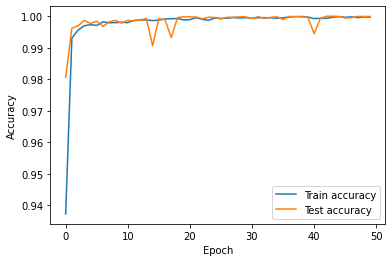

In [ ]:
history = model.fit(x_train, y_train_hot, batch_size=256, epochs=50, validation_data=(x_test, y_test_hot), verbose=1)

plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 8. Изменение **активационных** функций

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), activation='elu', padding='same', input_shape=(x_train.shape[1], x_train.shape[2], channel)))
model.add(Conv2D(32, kernel_size=(3,3), activation='elu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128,activation='elu'))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Dense(n_classes, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

### Обучение и график

Epoch 1/50
252/252 [==============================] - 3s 11ms/step - loss: 0.2452 - accuracy: 0.9271 - val_loss: 0.0287 - val_accuracy: 0.9897
Epoch 2/50
252/252 [==============================] - 2s 9ms/step - loss: 0.0191 - accuracy: 0.9956 - val_loss: 0.0072 - val_accuracy: 0.9979
Epoch 3/50
252/252 [==============================] - 2s 10ms/step - loss: 0.0104 - accuracy: 0.9973 - val_loss: 0.0054 - val_accuracy: 0.9984
Epoch 4/50
252/252 [==============================] - 2s 9ms/step - loss: 0.0065 - accuracy: 0.9981 - val_loss: 0.0041 - val_accuracy: 0.9983
Epoch 5/50
252/252 [==============================] - 2s 9ms/step - loss: 0.0051 - accuracy: 0.9984 - val_loss: 0.0069 - val_accuracy: 0.9973
Epoch 6/50
252/252 [==============================] - 2s 10ms/step - loss: 0.0056 - accuracy: 0.9982 - val_loss: 0.0049 - val_accuracy: 0.9978
Epoch 7/50
252/252 [==============================] - 2s 9ms/step - loss: 0.0050 - accuracy: 0.9984 - val_loss: 0.0024 - val_accuracy: 0.9992
Epo

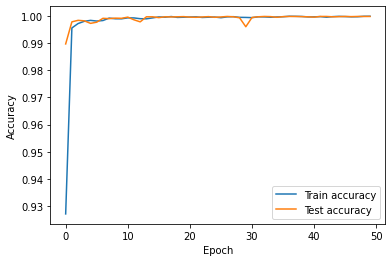

In [ ]:
history = model.fit(x_train, y_train_hot, batch_size=256, epochs=50, validation_data=(x_test, y_test_hot), verbose=1)

plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **Изменение обучающих данных**

Добавление новых Feature. Для этого обратимся к документации:
https://librosa.org/doc/latest/index.html

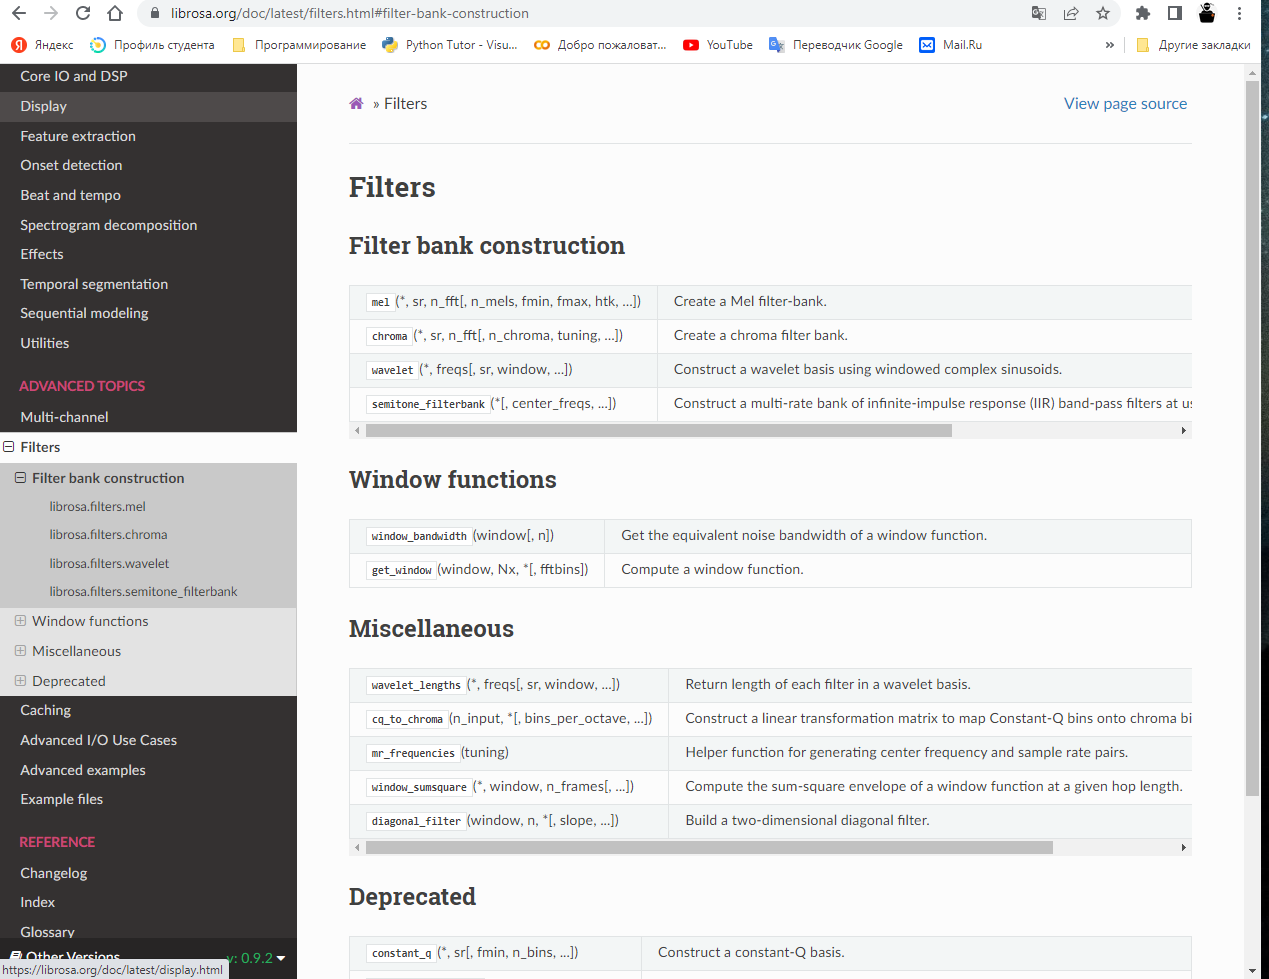

Добавим в функцию извлечение новых **Feature**.

In [ ]:
def wav2mfcc(file_path, length=11025, step=2205):
  out = []
  out_audio = []
  y, sr = librosa.load(file_path)

  while (len(y) >= length):

    out_section = []
    section = y[:length]
    section = np.array(section)
    
    # --------------------------------------------------------------------------------
    # Признаки из урока
    # --------------------------------------------------------------------------------

    mfcc = librosa.feature.mfcc(section, sr=sr)
  
    # --------------------------------------------------------------------------------
    # Новые признаки 
    # --------------------------------------------------------------------------------

    # chroma_stft = librosa.feature.chroma_stft(section, sr=sr)
    # rmse = librosa.feature.rms(section)
    # spec_cent = librosa.feature.spectral_centroid(section, sr=sr)
    # cpec_bw = librosa.feature.spectral_bandwidth(section, sr=sr)
    # rolloff = librosa.feature.spectral_rolloff(section, sr=sr)
    # zcr = librosa.feature.zero_crossing_rate(section)


    # --------------------------------------------------------------------------------
    # Добавим новые признаки (среднее значение)
    # --------------------------------------------------------------------------------

  #   spectral_flatness = np.mean(librosa.feature.spectral_flatness(section))                               # Вычисление спектральной плоскостности
    
  
  #   # Обнаружение начала
  #   onset_detect = librosa.onset.onset_detect(section, sr=sr, units='time')                               # Нахождение начального события заметки, выбирая пики в огибающей силы начала.
  #   onset_strength = librosa.onset.onset_strength(section, sr=sr)                                         # Вычисление огибающую силы начала спектрального потока
  #  #onset_backtrack = librosa.onset.onset_backtrack(onset_detect, onset_strength)
  #   onset_subbands = librosa.onset.onset_strength_multi(section, sr=sr) #, channels=[0, 32, 64, 96, 128]) # Вычисление огибающую силы начала спектрального потока по нескольким каналам


  #   # Бит и темп
  #   tempo, beats = librosa.beat.beat_track(section, sr=sr)                                                # Динамическое программирование трекера битов.
  #   beats = np.mean(beats)
    
  #   plp = librosa.beat.plp(onset_envelope=onset_strength, sr=sr)
  #   prior = scipy.stats.lognorm(loc=np.log(120), scale=120, s=1)
  #   beats_plp = librosa.beat.plp(onset_envelope=onset_strength, sr=sr, prior=prior)

  #   plp = np.mean(plp)
  #   beats_plp = np.mean(beats_plp)

    
  #   onset_detect = np.mean(onset_detect)
  #   onset_strength = np.mean(onset_strength)
  #   #onset_backtrack = np.mean(onset_backtrack)
  #   onset_subbands = np.mean(onset_subbands)

  #   # --------------------------------------------------------------------------------
  #   #  Добавим новые признаки по которым в дальнейшем будем проходиться циклом
  #   # --------------------------------------------------------------------------------

  #   # Спектральные особенности
  #   chroma_cqt = librosa.feature.chroma_cqt(section, sr=sr)         # Constant-Q хроматограмма
  #   chroma_cens = librosa.feature.chroma_cens(section, sr=sr)       # Вычисление варианта цветности «Нормализованная энергия цветности» (CENS)
  #   melspectrogram = librosa.feature.melspectrogram(section, sr=sr) # Вычисление спектрограммы в масштабе мела.
  #   spectral_contrast = librosa.feature.spectral_contrast(section)  # Вычисление спектрального контраста
  #   poly_features = librosa.feature.poly_features(section, sr=sr)   # Получение коэффициента подгонки полинома n-го порядка к столбцам спектрограммы.
  #   tonnetz = librosa.feature.tonnetz(section, sr=sr)               # Вычисление тонального центроида.


  #   # Особенности ритма
  #   tempogram = librosa.feature.tempogram(section, sr=sr)                   # Вычисление темпограммы: локальная автокорреляция огибающей начальной силы.
  #   fourier_tempogram = librosa.feature.fourier_tempogram(section, sr=sr)   # Вычисление темпограммы Фурье: кратковременное преобразование Фурье огибающей силы начала.

  #   # Манипуляции с функциями
  #   mfcc_delta = librosa.feature.delta(mfcc)                      # Вычисление дельта-функции: локальная оценка производной входных данных по выбранной оси.
  #   mfcc_delta2 = librosa.feature.delta(mfcc, order=2)            # Второго порядка
  #   stack_memory = librosa.feature.stack_memory(data=section)     # Встраивание краткосрочной истории: вертикальное объединение вектора данных или матрицы с отложенными копиями самих себя.

    
  #   # Инверсия признаков
  #   mfcc_to_mel = librosa.feature.inverse.mfcc_to_mel(mfcc)    # Инвертируемые кепстральные коэффициенты Mel-частоты


    # --------------------------------------------------------------------------------
    #  Добавление в массив всех признаков
    # --------------------------------------------------------------------------------

    # out_section.append(mfcc)
    # out_section.append(chroma_stft)
    # out_section.append(rmse)
    # out_section.append(spec_cent)
    # out_section.append(cpec_bw)
    # out_section.append(rolloff)
    # out_section.append(zcr)

  #   out.append(spectral_flatness)
  #   out.append(onset_detect)
  #   out.append(onset_strength)
  #  #out.append(onset_backtrack)
  #   out.append(onset_subbands)
  #   out.append(tempo)
  #   out.append(beats)
  #   out.append(plp)
  #   out.append(beats_plp)

  #   for i in chroma_cqt:
  #     out.append(np.mean(i)) 
  
  #   for i in chroma_cens:
  #     out.append(np.mean(i)) 
    
  #   for i in melspectrogram:
  #     out.append(np.mean(i)) 
    
  #   for i in spectral_contrast:
  #     out.append(np.mean(i)) 
    
  #   for i in poly_features:
  #     out.append(np.mean(i)) 
    
  #   for i in tonnetz:
  #     out.append(np.mean(i))
    
  #   for i in tempogram:
  #     out.append(np.mean(i))
  
  #   for i in fourier_tempogram:
  #     out.append(np.mean(i))
    
  #   for i in mfcc_delta:
  #     out.append(np.mean(i))

  #   for i in mfcc_delta2:
  #     out.append(np.mean(i))

  #   for i in stack_memory:
  #     out.append(np.mean(i))

  #   for i in mfcc_to_mel:
  #     out.append(np.mean(i))
    
    out.append(out_section)
    out_audio.append(section)
    y = y[step:]

  out = np.array(out)
  out_audio = np.array(out_audio)

  return out, out_audio

In [ ]:
# Функция параметризации аудио
def wav2mfcc(file_path, length=11025, step=2205):
  out_mfcc = []
  out_audio = []
  y, sr = librosa.load(file_path)

  while (len(y) > length):
    out_section = []

    section = y[:length]
    section = np.array(section)

    mfcc = librosa.feature.mfcc(section, sr)
    chroma_stft = librosa.feature.chroma_stft(section, sr=sr)

    rms = librosa.feature.rms(section)
    spec_cent = librosa.feature.spectral_centroid(section, sr=sr)
    spec_bnw = librosa.feature.spectral_bandwidth(section, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(section, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(section)

    # onset_detect = librosa.onset.onset_detect(section, sr=sr, units='time')                               # Нахождение начального события заметки, выбирая пики в огибающей силы начала.
    # onset_strength = librosa.onset.onset_strength(section, sr=sr)                                         # Вычисление огибающую силы начала спектрального потока
    # onset_backtrack = librosa.onset.onset_backtrack(onset_detect, onset_strength)
    # onset_subbands = librosa.onset.onset_strength_multi(section, sr=sr) #, channels=[0, 32, 64, 96, 128]) # Вычисление огибающую силы начала спектрального потока по нескольким каналам

    #tempo, beats = librosa.beat.beat_track(section, sr=sr) 

    # Спектральные особенности
    chroma_cqt = librosa.feature.chroma_cqt(section, sr=sr)         # Constant-Q хроматограмма
    chroma_cens = librosa.feature.chroma_cens(section, sr=sr)       # Вычисление варианта цветности «Нормализованная энергия цветности» (CENS)
    melspectrogram = librosa.feature.melspectrogram(section, sr=sr) # Вычисление спектрограммы в масштабе мела.
    spectral_contrast = librosa.feature.spectral_contrast(section)  # Вычисление спектрального контраста
    poly_features = librosa.feature.poly_features(section, sr=sr)   # Получение коэффициента подгонки полинома n-го порядка к столбцам спектрограммы.
    tonnetz = librosa.feature.tonnetz(section, sr=sr)

    out_section.extend(mfcc)

    out_section.extend(chroma_stft)
    out_section.extend(rms)
    out_section.extend(spec_cent)
    out_section.extend(spec_bnw)
    out_section.extend(rolloff)
    out_section.extend(zcr)

    # out_section.extend(onset_detect)
    # out_section.extend(onset_strength)
    # out_section.extend(onset_backtrack)
    # out_section.extend(onset_subbands)

    # out_section.extend(tempo)
    # out_section.extend(beats)

    out_section.extend(chroma_cqt)
    out_section.extend(chroma_cens)
    out_section.extend(melspectrogram)
    out_section.extend(spectral_contrast)
    out_section.extend(poly_features)
    out_section.extend(tonnetz)



    out_mfcc.append(out_section)
    out_audio.append(section)
    y = y[step:]
  
  out_mfcc = np.array(out_mfcc)
  out_audio = np.array(out_audio)

  return out_mfcc, out_audio

In [ ]:
# Сформируем векторные данные и сохраним
save_data_to_array(length=feature_dim_2)

Сохраняем векторы класса - 4_noise:  44%|████▍     | 22/50 [4:49:02<6:07:24, 787.30s/it]

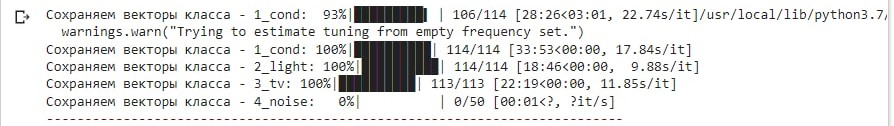

Последний numpy массив с шумом **4_noise** не создался. Выдал ошибку. Поэтому создадим его отдельно.

In [ ]:
labels = '4_noise'
mfcc_vectors = []
wavfiles = [DATA_PATH + labels + '/' + i for i in os.listdir(DATA_PATH + labels) ]
for wavfile in tqdm(wavfiles, f"Сохраняем векторы класса - {labels}"):
  mfcc, _ = wav2mfcc(wavfile)
  if mfcc.shape[0] != 0:
    mfcc_vectors.extend(mfcc)
np.save(f'{labels}.npy', mfcc_vectors)

Сохраняем векторы класса - 4_noise:   0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=690
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=345
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=173
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")
Сохраняем векторы класса - 4_noise: 100%|███████

In [ ]:
cond = np.load('/content/1_cond.npy')
cond.shape

(3584, 204, 22)

In [ ]:
light = np.load('/content/2_light.npy')
light.shape

(1966, 204, 22)

In [ ]:
tv = np.load('/content/3_tv.npy')
tv.shape

(2347, 204, 22)

In [ ]:
noise = np.load('/content/4_noise.npy')
noise.shape

(14507, 204, 22)

In [ ]:
# Функция для получения обучающей/проверочной выборки
def get_train_test(split_ratio=0.8, random_state=42, colab=False):
  labels, indices, _ = get_labels(DATA_PATH)

  X = np.load('/content/1_cond.npy')
  y = np.zeros(X.shape[0], dtype='int32')

  for i, label in enumerate(labels[1:]):
    if colab:
      x = np.load(label + '.npy')
    else:
      x = np.load('/content/drive/MyDrive/УИИ/Распознавание речи/Numpy/' + label + '.npy')

    X = np.vstack((X, x))
    y = np.append(y, np.full(x.shape[0], fill_value= (i + 1)))
  
  return train_test_split(X, y, test_size=(1-split_ratio), random_state=random_state, shuffle=True)

In [ ]:
# Формируем обучающую и проверочную выборки
x_train, x_test, y_train, y_test = get_train_test(colab=True)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(17923, 204, 22)
(4481, 204, 22)
(17923,)
(4481,)


In [ ]:
# Добавляем значение канала
x_train = x_train[..., None]
x_test = x_test[..., None]

print(x_train.shape)
print(x_test.shape)

(17923, 204, 22, 1)
(4481, 204, 22, 1)


In [ ]:
# представляем лейблы классов обучающего набора в виде one-hot вектора
y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)

print(y_train_hot.shape)
print(y_test_hot.shape)

(17923, 4)
(4481, 4)


# Обучение нейронной сети на новых данных

In [ ]:
model = Sequential()
model.add(Conv2D(8, kernel_size=(3,3), activation='relu', input_shape=(x_train.shape[1], x_train.shape[2], channel)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Dense(n_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train_hot, batch_size=256, epochs=50, validation_data=(x_test, y_test_hot), verbose=1)

Epoch 1/50
71/71 [==============================] - 26s 350ms/step - loss: 0.5417 - accuracy: 0.8071 - val_loss: 0.2644 - val_accuracy: 0.9076
Epoch 2/50
71/71 [==============================] - 23s 328ms/step - loss: 0.1735 - accuracy: 0.9450 - val_loss: 0.1618 - val_accuracy: 0.9471
Epoch 3/50
71/71 [==============================] - 24s 342ms/step - loss: 0.1036 - accuracy: 0.9681 - val_loss: 0.1078 - val_accuracy: 0.9710
Epoch 4/50
71/71 [==============================] - 27s 376ms/step - loss: 0.0734 - accuracy: 0.9766 - val_loss: 0.1328 - val_accuracy: 0.9627
Epoch 5/50
71/71 [==============================] - 24s 344ms/step - loss: 0.0597 - accuracy: 0.9828 - val_loss: 0.0898 - val_accuracy: 0.9732
Epoch 6/50
71/71 [==============================] - 23s 330ms/step - loss: 0.0805 - accuracy: 0.9742 - val_loss: 0.0796 - val_accuracy: 0.9770
Epoch 7/50
71/71 [==============================] - 24s 345ms/step - loss: 0.0673 - accuracy: 0.9806 - val_loss: 0.1703 - val_accuracy: 0.9543

# Выводы:

1. В данном задание были проведены эксперименты с архитертурой нейронной сети.
2. Были добавлены слои:
  - Conv2D
  - MaxPolling2D
  - Dropout
  - BatchNormalization
  - Dense
3. Так же были изменены различные гиперпараметры и активационный функции.
4. Был эксперимет с изменением обучающих данных:      извлечение новых признаков из аудио.
5. В целом результаты примерно одинаковые.
6. Для более сложных задач, требуется подбор более оптимальной архитектуры нейронной сети. А так же нормализация и подготовка входных данных.